In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
class NNDataset(Dataset):

    def __init__(self, func=torch.sin, begin=0, end=np.pi, size=10000) -> None:
        self.x = torch.FloatTensor(np.linspace(begin, end, size).reshape((size, 1)))
        self.t = func(self.x)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.t[index]

In [22]:
class TensorView(nn.Module):

    def forward(self, x):
        x = torch.Tensor(x)
        if x.ndim == 1:
            x = x[None, ...]
        return x

In [25]:
class ImageView(nn.Module):

    def forward(self, x: torch.Tensor):
        batch_size = x.shape[0]
        return x.view(batch_size, 1, 16, 16)

In [ ]:
# nn.Conv2d(1, 10, kernel_size=5, stride=2),
#             nn.LeakyReLU(),
#             nn.BatchNorm2d(10),
#             nn.Conv2d(10, 10, kernel_size=3, stride=2),
#             nn.LeakyReLU(),
#             nn.BatchNorm2d(10),

In [60]:
class Model(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            TensorView(),
            nn.Linear(1, 256),
            ImageView(),

            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(10),

            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(40, 10),
            nn.Sigmoid(),
            nn.Linear(10, 1),
            # nn.Sigmoid(),
        )

        # self.loss_function = nn.BCEWithLogitsLoss()
        # self.loss_function = nn.BCELoss()
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, x):
        return self.model(x)

# net = Model()
# image = net.forward([0.1])
# print(image.shape)
# ax = plt.figure().add_subplot()
# ax.imshow(image.detach().numpy().reshape(2, 5))
# plt.show()

In [61]:
epoch = 100
batch_size = 500

dataset = NNDataset()
net = Model()

bar = tqdm(range(epoch))

generator = None

for e in bar:
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
    )

    for x, t in dataloader:
        y = net.forward(x)

        loss = net.loss_function(y, t)

        net.optimizer.zero_grad()

        loss.backward()

        net.optimizer.step()

        bar.set_postfix(dict(loss=f"{loss.item():0.2}",))


100%|██████████| 100/100 [00:40<00:00,  2.48it/s, loss=1.7e-05]


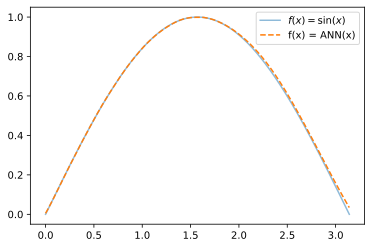

In [62]:
ax = plt.figure().add_subplot()
ax.plot(dataset.x.flatten(), dataset.t.flatten(), label='$f(x)=\sin(x)$', alpha=0.5)
ax.plot(dataset.x.flatten(), net.forward(dataset.x).detach().flatten(), '--', label='f(x) = ANN(x)')
ax.legend()
plt.show()